In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [4]:
#分别得到坐标值和feature
#print(set(data['Yaw_Angle'].values),len(data['Yaw_Angle'].values))
data = pd.read_csv('处理数据/标准化数据.csv')
position_global = np.array(data[['Global_X','Global_Y']])
position_local =  np.array(data[['Local_X','Local_Y']])
#vehicle_feature = np.array(data.drop(['Vehicle_ID','Frame_ID','Total_Frames','Global_Time','Global_X','Global_Y','Location_peachtree'],
        #                            axis=1))
vehicle_feature = np.array(data[['Local_X','Local_Y',
                                 'v_length','v_Width','v_Class_1','v_Class_2',
                                 'v_Class_3','v_Vel','v_Acc','Preceding','Following',
                                 'Direction_1',
                                 'Direction_2','Direction_3','Direction_4','Movement_1','Movement_2','Movement_3','Yaw_Angle'
                              ]])

vehicle_label = np.zeros_like(position_local)
vehicle_label[:-1],vehicle_label[-1] = position_local[1:],position_local[0]
#vehicle_label = position_local
vehicle_feature = vehicle_feature.astype(np.float32)
vehicle_label = vehicle_label.astype(np.float32)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
train_x,val_test_x = vehicle_feature[:int(len(vehicle_feature)*split_frac)],vehicle_feature[int(len(vehicle_feature)*split_frac):]
val_x,test_x = val_test_x[:len(val_test_x)//2],val_test_x[len(val_test_x)//2:]

train_y,val_test_y = vehicle_label[:int(len(vehicle_label)*split_frac)],vehicle_label[int(len(vehicle_label)*split_frac):]
val_y,test_y = val_test_y[:len(val_test_y)//2],val_test_y[len(val_test_y)//2:]


import torch
from torch.utils.data import TensorDataset, DataLoader
 
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


# dataloaders
batch_size = 512

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

#iters = iter(train_loader)
#x, y = next(iters)
#print(x,y)
#得到车辆数
vehicle_id = np.array(data['Vehicle_ID'])
print('总采样数为:',len(vehicle_feature))
print('总车辆数为:',len(np.unique(vehicle_id)))



总采样数为: 1676606
总车辆数为: 1545


In [5]:
data1 = pd.read_csv('data/NGSIM_Peachtree_Vehicle_Trajectories.csv')
#data2 = pd.read_csv('data/NGSIM__Lankershim_Vehicle_Trajectories.csv')
data3  = pd.read_csv('data/Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv')

data_ = pd.concat([data1,data3],axis=0)
quant_features = ['Local_X','Local_Y','Global_X','Global_Y']
scaled_features = {}
print('start..')

for each in quant_features:
    mean, std = data_[each].mean(), data_[each].max()-data_[each].min()
    scaled_features[each] = [mean, std]
    data_.loc[:, each] = (data_[each] - mean)/std
mean_x, std_x = scaled_features['Local_X']
mean_y, std_y = scaled_features['Local_Y']
print(mean_x, std_x)
print(mean_y, std_y)

start..
0.2436986727949202 486.509
927.7015568869493 2113.03


In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.fc2 = nn.Linear(vehicle_feature.shape[1],output_size)
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        r_out = torch.mean(r_out,dim=2).squeeze()
        
        output= self.fc2(r_out)
       # print(r_out.shape)#(512,1,512)
        # shape output to be (batch_size*seq_length, hidden_dim)
       #r_out = r_out.contiguous().view(-1, self.hidden_dim)  
       # print(r_out.shape)(512,512)
        # get final output 
      # output = self.fc1(r_out)
     #  output = self.fc(output)
   #    output = output.view(batch_size,-1,2)
      # print(output.shape)
    #   output = output[:,-1]
       # print(output.shape)
        
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False

In [7]:
def train(net,epochs,train_loader,valid_loader,clip,print_every,lr = 0.0002):
    # train for some number of epochs
    # loss and optimization functions

    loss_min = np.inf
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    counter = 0
    for e in range(epochs):
        # initialize hidden state

        # batch loop
        for inputs, labels in train_loader:
            h = net.init_hidden(inputs.shape[0])
            counter += 1
            h = tuple([each.data for each in h])
            inputs = inputs.unsqueeze(2)
            if (train_on_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output, h = net(inputs, h)

            # calculate the loss and perform backprop
          #  print(output.shape,labels.shape)
            loss = criterion(output, labels)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss

                val_losses = []
                net.eval()
                accuracy = []
                for inputs, labels in valid_loader:
                    val_h = net.init_hidden(inputs.shape[0])
                    inputs = inputs.unsqueeze(2)
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                   # val_h = tuple([each.data for each in val_h])
                    val_h = tuple([each.data for each in val_h])
                    if (train_on_gpu):
                        inputs, labels = inputs.cuda(), labels.cuda()
                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, labels)
                    val_losses.append(val_loss.item())
                net.train()
                print("Epoch: {}/{}...".format(e + 1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {}...".format(loss.item()),
                      "Val Loss: {}...".format(np.mean(val_losses)),)
                if np.mean(val_losses) < loss_min:
                    print('Val loss decreased...')
                    torch.save(net.state_dict(),'model/lstm_trajectory_prediction_old_mean.pt')
                    loss_min = np.mean(val_losses)
    print('min loss:',loss_min)

In [8]:
def test(net,test_loader):
    # Get test data loss and accuracy
    lr = 0.001

    criterion = nn.MSELoss()
    test_losses = []  # track loss
    num_correct = 0

    # init hidden stat

    net.eval()
    # iterate over test data
    for inputs, labels in test_loader:
        h = net.init_hidden(inputs.shape[0])
        inputs = inputs.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        if (train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        # get predicted outputs
        output, h = net(inputs, h)

        # calculate loss
        test_loss = criterion(output, labels)
        test_losses.append(test_loss.item())


    print("Test loss: {:.3f}".format(np.mean(test_losses)))


In [23]:
def predict(net, test_loader):
    valid_loss = []
    criterion = nn.MSELoss()
    actual_angles,predict_angles = [],[]
    for i_, (x, y) in enumerate(test_loader):
        h = net.init_hidden(x.shape[0])
        x = x.unsqueeze(2)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        if i_ == 20:
            break
        if train_on_gpu:
            x, y = x.cuda(), y.cuda()
        out,h = net(x,h)

        loss = criterion(out, y)
        valid_loss.append(loss.item())
        y = y.cpu().detach().numpy().tolist()
        out = out.cpu().detach().numpy().tolist()
        print('Test Loss:', np.mean(valid_loss))
        actual_angle,predict_angle = [],[]
        actual_length = y[:30]
        predict_length = out[:30]
        for i in range(len(actual_length)-1):
            actual_angle.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
            actual_angles.append(math.atan2((actual_length[i+1][1]*std_y + mean_y)-(actual_length[i][1]*std_y + mean_y),
                                           (actual_length[i+1][0]*std_x + mean_x) -(actual_length[i][0]*std_x + mean_x)))
        for i in range(len(predict_length)-1):
            predict_angle.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
            predict_angles.append(math.atan2((predict_length[i+1][1]*std_y + mean_y)-(predict_length[i][1]*std_y + mean_y),
                                           (predict_length[i+1][0]*std_x + mean_x)-(predict_length[i][0]*std_x + mean_x)))
        for i in range(len(actual_angle)):
            print("actuale_angle_{}:{},prdict_angle_{}:{}".format(i,actual_angle[i],i,predict_angle[i]))
        plt.scatter([s[0] * std_x + mean_x for s in y[:30]],[s[1] * std_y + mean_y for s in y[:30]], color='r',
                    label='actual_trajectory')
        plt.scatter([s[0] * std_x + mean_x for s in out[:30]], [s[1] * std_y + mean_y for s in out[:30]], color='b',
                    label='predict_trajectory')
        plt.legend() 
        plt.title('Trajectory')
        plt.savefig('trajectory_image/trajectory/trajectory_old_mean/png/trajectory_old_mean_{}.png'.format(i_),dpi=300)
        plt.savefig('trajectory_image/trajectory/trajectory_old_mean/svg/trajectory_old_mean_{}.svg'.format(i_),dpi=300)
        plt.show()
    return actual_angles,predict_angles


In [12]:
net = LSTM(1,2,256,2)

if train_on_gpu:
    net.cuda()
from time import time
start = time()
epochs = 60
train(net,epochs,train_loader,valid_loader,clip=5,print_every=100,lr=0.0001)
print('Training Time is',time()-start,'s')

Epoch: 1/60... Step: 100... Loss: 0.045971713960170746... Val Loss: 0.003251665001543432...
Val loss decreased...
Epoch: 1/60... Step: 200... Loss: 0.006558239459991455... Val Loss: 0.0046811894728041184...
Epoch: 1/60... Step: 300... Loss: 0.00651564821600914... Val Loss: 0.0069956215417577615...
Epoch: 1/60... Step: 400... Loss: 0.038832444697618484... Val Loss: 0.01036954216432627...
Epoch: 1/60... Step: 500... Loss: 0.07877293974161148... Val Loss: 0.01010849120921637...
Epoch: 1/60... Step: 600... Loss: 0.09480775147676468... Val Loss: 0.013542337373620263...
Epoch: 1/60... Step: 700... Loss: 0.011701655574142933... Val Loss: 0.01308884689152786...
Epoch: 1/60... Step: 800... Loss: 0.05020534247159958... Val Loss: 0.006550265012220934...
Epoch: 1/60... Step: 900... Loss: 0.02472870983183384... Val Loss: 0.013888672594741986...
Epoch: 1/60... Step: 1000... Loss: 0.057214222848415375... Val Loss: 0.01227835167011973...
Epoch: 1/60... Step: 1100... Loss: 0.009244387969374657... Val L

Epoch: 4/60... Step: 8900... Loss: 0.008567032404243946... Val Loss: 0.004215234791911094...
Epoch: 4/60... Step: 9000... Loss: 0.002413352718576789... Val Loss: 0.004598961163116279...
Epoch: 4/60... Step: 9100... Loss: 0.0013661992270499468... Val Loss: 0.004330613370345928...
Epoch: 4/60... Step: 9200... Loss: 0.002490534447133541... Val Loss: 0.0038539321259765816...
Epoch: 4/60... Step: 9300... Loss: 0.0007854938739910722... Val Loss: 0.003987157947693315...
Epoch: 4/60... Step: 9400... Loss: 0.0030318833887577057... Val Loss: 0.003756291559888845...
Epoch: 4/60... Step: 9500... Loss: 0.0008274193969555199... Val Loss: 0.003634516130415893...
Epoch: 4/60... Step: 9600... Loss: 0.0003398183616809547... Val Loss: 0.008219268505898781...
Epoch: 4/60... Step: 9700... Loss: 0.0007139106746762991... Val Loss: 0.028095321876008245...
Epoch: 4/60... Step: 9800... Loss: 2.7055506507167593e-05... Val Loss: 0.021729931859980997...
Epoch: 4/60... Step: 9900... Loss: 0.0007572988979518414... V

Epoch: 7/60... Step: 17500... Loss: 0.0001570533204358071... Val Loss: 0.0038788287281754383...
Epoch: 7/60... Step: 17600... Loss: 0.0008949334733188152... Val Loss: 0.008951984810154521...
Epoch: 7/60... Step: 17700... Loss: 9.417910769116133e-05... Val Loss: 0.0070013782583040795...
Epoch: 7/60... Step: 17800... Loss: 0.0003090171958319843... Val Loss: 0.007500570074004893...
Epoch: 7/60... Step: 17900... Loss: 0.00026660787989385426... Val Loss: 0.006292323657473345...
Epoch: 7/60... Step: 18000... Loss: 0.0006142214988358319... Val Loss: 0.007132852322950096...
Epoch: 7/60... Step: 18100... Loss: 0.00020247537759132683... Val Loss: 0.01197498804952086...
Epoch: 7/60... Step: 18200... Loss: 0.0003468963841442019... Val Loss: 0.007317601636381502...
Epoch: 7/60... Step: 18300... Loss: 0.0008737954194657505... Val Loss: 0.005246809788088019...
Epoch: 8/60... Step: 18400... Loss: 0.002878796774893999... Val Loss: 0.00761407328394764...
Epoch: 8/60... Step: 18500... Loss: 0.00153635721

Epoch: 10/60... Step: 25700... Loss: 0.00017208837380167097... Val Loss: 0.001054243696072684...
Epoch: 10/60... Step: 25800... Loss: 0.00025054713478311896... Val Loss: 0.0010930991517919366...
Epoch: 10/60... Step: 25900... Loss: 0.00035091093741357327... Val Loss: 0.0021251696134419124...
Epoch: 10/60... Step: 26000... Loss: 0.0005752959405072033... Val Loss: 0.005260733503524623...
Epoch: 10/60... Step: 26100... Loss: 0.0003774442302528769... Val Loss: 0.0037560432928574567...
Epoch: 10/60... Step: 26200... Loss: 0.0007878405740484595... Val Loss: 0.0016091881020323987...
Epoch: 11/60... Step: 26300... Loss: 8.308045653393492e-05... Val Loss: 0.0009817152966694798...
Epoch: 11/60... Step: 26400... Loss: 0.0005781983491033316... Val Loss: 0.0009609328317754084...
Epoch: 11/60... Step: 26500... Loss: 0.0011672771070152521... Val Loss: 0.0009077493331704584...
Epoch: 11/60... Step: 26600... Loss: 6.726814899593592e-05... Val Loss: 0.0008895578238724094...
Epoch: 11/60... Step: 26700..

Epoch: 14/60... Step: 34100... Loss: 0.000820694665890187... Val Loss: 0.0011856366087691064...
Epoch: 14/60... Step: 34200... Loss: 0.0002946547756437212... Val Loss: 0.0008898447538784949...
Epoch: 14/60... Step: 34300... Loss: 0.0008963790605776012... Val Loss: 0.0008877200260740654...
Epoch: 14/60... Step: 34400... Loss: 1.5589143004035577e-05... Val Loss: 0.0009045712748646599...
Epoch: 14/60... Step: 34500... Loss: 8.390939910896122e-05... Val Loss: 0.0009390343841848179...
Epoch: 14/60... Step: 34600... Loss: 0.00010542102245381102... Val Loss: 0.0009447909344267029...
Epoch: 14/60... Step: 34700... Loss: 2.6562058337731287e-05... Val Loss: 0.0009629630350634504...
Epoch: 14/60... Step: 34800... Loss: 0.0006174839218147099... Val Loss: 0.000979388883490351...
Epoch: 14/60... Step: 34900... Loss: 0.00015271945449057966... Val Loss: 0.0025979307495773113...
Epoch: 14/60... Step: 35000... Loss: 0.0004694199888035655... Val Loss: 0.000997219096084669...
Epoch: 14/60... Step: 35100..

Epoch: 17/60... Step: 42600... Loss: 0.0008656089194118977... Val Loss: 0.0009650454831544044...
Epoch: 17/60... Step: 42700... Loss: 0.0027771578170359135... Val Loss: 0.001198646503148555...
Epoch: 17/60... Step: 42800... Loss: 7.37816299078986e-05... Val Loss: 0.0009920077308623416...
Epoch: 17/60... Step: 42900... Loss: 0.0038563283160328865... Val Loss: 0.0010259161737804989...
Epoch: 17/60... Step: 43000... Loss: 2.9346578230615705e-05... Val Loss: 0.0009796917923423035...
Epoch: 17/60... Step: 43100... Loss: 4.818980596610345e-05... Val Loss: 0.0009684075085471439...
Epoch: 17/60... Step: 43200... Loss: 0.001574610359966755... Val Loss: 0.0010077435533120723...
Epoch: 17/60... Step: 43300... Loss: 0.0018882369622588158... Val Loss: 0.000988157041929964...
Epoch: 17/60... Step: 43400... Loss: 0.002071904018521309... Val Loss: 0.0009841488105915388...
Epoch: 17/60... Step: 43500... Loss: 0.0008312175050377846... Val Loss: 0.0009866736603970179...
Epoch: 17/60... Step: 43600... Los

Epoch: 20/60... Step: 51100... Loss: 0.0003262146492488682... Val Loss: 0.0009451012094093418...
Epoch: 20/60... Step: 51200... Loss: 5.488661918207072e-05... Val Loss: 0.0009758355392877115...
Epoch: 20/60... Step: 51300... Loss: 0.0008647568174637854... Val Loss: 0.0009452743032209294...
Epoch: 20/60... Step: 51400... Loss: 1.1427015124354511e-05... Val Loss: 0.0009431764302883871...
Epoch: 20/60... Step: 51500... Loss: 0.00023362455249298364... Val Loss: 0.0010138631408752677...
Epoch: 20/60... Step: 51600... Loss: 0.00035810095141641796... Val Loss: 0.00116069942961941...
Epoch: 20/60... Step: 51700... Loss: 0.0004861641500610858... Val Loss: 0.001232152224696531...
Epoch: 20/60... Step: 51800... Loss: 0.00040584930684417486... Val Loss: 0.0012362955167191103...
Epoch: 20/60... Step: 51900... Loss: 0.00016800552839413285... Val Loss: 0.0013745330692383905...
Epoch: 20/60... Step: 52000... Loss: 0.0002607134520076215... Val Loss: 0.0014461679215523097...
Epoch: 20/60... Step: 52100.

Epoch: 23/60... Step: 59600... Loss: 0.00018206480308435857... Val Loss: 0.0010494126330652252...
Epoch: 23/60... Step: 59700... Loss: 0.0002870302414521575... Val Loss: 0.0010903593752229382...
Epoch: 23/60... Step: 59800... Loss: 0.00031162562663666904... Val Loss: 0.001136090143008027...
Epoch: 23/60... Step: 59900... Loss: 0.0003261829260736704... Val Loss: 0.0012216872515060325...
Epoch: 23/60... Step: 60000... Loss: 0.00025873890263028443... Val Loss: 0.0012698616614570933...
Epoch: 23/60... Step: 60100... Loss: 0.00024049925559666008... Val Loss: 0.0011126113491272695...
Epoch: 23/60... Step: 60200... Loss: 0.000533769023604691... Val Loss: 0.0010499501227391969...
Epoch: 24/60... Step: 60300... Loss: 0.00038199222763068974... Val Loss: 0.0019006246103544537...
Epoch: 24/60... Step: 60400... Loss: 3.231641312595457e-05... Val Loss: 0.0009170858075754595...
Epoch: 24/60... Step: 60500... Loss: 0.0008865228737704456... Val Loss: 0.0009319698230639206...
Epoch: 24/60... Step: 60600

Epoch: 26/60... Step: 68100... Loss: 0.000778200279455632... Val Loss: 0.0010684912235663477...
Epoch: 27/60... Step: 68200... Loss: 7.485074456781149e-05... Val Loss: 0.0009044998505709284...
Epoch: 27/60... Step: 68300... Loss: 0.0014691650867462158... Val Loss: 0.0009238416767447034...
Epoch: 27/60... Step: 68400... Loss: 6.734881026204675e-05... Val Loss: 0.0009279082072037166...
Epoch: 27/60... Step: 68500... Loss: 0.0012722655665129423... Val Loss: 0.0009460787713822621...
Epoch: 27/60... Step: 68600... Loss: 8.27311032480793e-06... Val Loss: 0.0009291771694046385...
Epoch: 27/60... Step: 68700... Loss: 2.7804591809399426e-05... Val Loss: 0.0009336964217365631...
Epoch: 27/60... Step: 68800... Loss: 0.0008318561594933271... Val Loss: 0.0009309500535048911...
Epoch: 27/60... Step: 68900... Loss: 0.001089458353817463... Val Loss: 0.0010857956239771916...
Epoch: 27/60... Step: 69000... Loss: 5.365725883166306e-05... Val Loss: 0.0010169743519970614...
Epoch: 27/60... Step: 69100... L

Epoch: 30/60... Step: 76600... Loss: 7.114414984243922e-06... Val Loss: 0.0009408909757151311...
Epoch: 30/60... Step: 76700... Loss: 2.147437226085458e-05... Val Loss: 0.0009282920477189914...
Epoch: 30/60... Step: 76800... Loss: 0.0016286366153508425... Val Loss: 0.0012761110636169976...
Epoch: 30/60... Step: 76900... Loss: 5.626354686683044e-05... Val Loss: 0.0009778839361299506...
Epoch: 30/60... Step: 77000... Loss: 3.137251769658178e-05... Val Loss: 0.000929726441005719...
Epoch: 30/60... Step: 77100... Loss: 1.1547190297278576e-05... Val Loss: 0.0009336667763131029...
Epoch: 30/60... Step: 77200... Loss: 2.669700279511744e-06... Val Loss: 0.0009296808657271003...
Epoch: 30/60... Step: 77300... Loss: 0.0003102345217484981... Val Loss: 0.0009218246556950518...
Epoch: 30/60... Step: 77400... Loss: 3.786634624702856e-05... Val Loss: 0.0009274959284306444...
Epoch: 30/60... Step: 77500... Loss: 0.0008601790759712458... Val Loss: 0.0009280833288557471...
Epoch: 30/60... Step: 77600...

Epoch: 33/60... Step: 85100... Loss: 0.0015351773472502828... Val Loss: 0.0009270993318196128...
Epoch: 33/60... Step: 85200... Loss: 9.09495065570809e-06... Val Loss: 0.0009201747457043938...
Epoch: 33/60... Step: 85300... Loss: 0.000751740240957588... Val Loss: 0.0009286462127087495...
Epoch: 33/60... Step: 85400... Loss: 0.0008046019356697798... Val Loss: 0.000930048238132724...
Epoch: 33/60... Step: 85500... Loss: 0.0013512985315173864... Val Loss: 0.0009322379792138236...
Epoch: 33/60... Step: 85600... Loss: 0.0001434337318642065... Val Loss: 0.0011511559282442294...
Epoch: 33/60... Step: 85700... Loss: 0.0010907528921961784... Val Loss: 0.0010792231517304416...
Epoch: 33/60... Step: 85800... Loss: 0.00017066960572265089... Val Loss: 0.000940536545430205...
Epoch: 33/60... Step: 85900... Loss: 0.000269559706794098... Val Loss: 0.0009511074653479537...
Epoch: 33/60... Step: 86000... Loss: 0.00028943008510395885... Val Loss: 0.00093431395526284...
Epoch: 33/60... Step: 86100... Loss

Epoch: 36/60... Step: 93600... Loss: 0.0006575122242793441... Val Loss: 0.0009882768247224726...
Epoch: 36/60... Step: 93700... Loss: 0.0002349030546611175... Val Loss: 0.0009252956216830459...
Epoch: 36/60... Step: 93800... Loss: 0.00025398924481123686... Val Loss: 0.0009680683688646063...
Epoch: 36/60... Step: 93900... Loss: 0.00020282779587432742... Val Loss: 0.0009867107575878547...
Epoch: 36/60... Step: 94000... Loss: 0.00041249970672652125... Val Loss: 0.0010451796104728312...
Epoch: 36/60... Step: 94100... Loss: 0.0005844295956194401... Val Loss: 0.0009817990045653793...
Epoch: 36/60... Step: 94200... Loss: 0.0005065937293693423... Val Loss: 0.0009207291238963967...
Epoch: 36/60... Step: 94300... Loss: 0.0007698009139858186... Val Loss: 0.0009769644853449568...
Epoch: 37/60... Step: 94400... Loss: 7.009867840679362e-05... Val Loss: 0.0008975221546900617...
Epoch: 37/60... Step: 94500... Loss: 0.001475128228776157... Val Loss: 0.0009110577548531958...
Epoch: 37/60... Step: 94600.

Epoch: 39/60... Step: 102100... Loss: 0.0004831066762562841... Val Loss: 0.0009523273965896806...
Epoch: 40/60... Step: 102200... Loss: 0.0009289889712817967... Val Loss: 0.0007740848124474102...
Val loss decreased...
Epoch: 40/60... Step: 102300... Loss: 0.00023085318389348686... Val Loss: 0.0008982049328374049...
Epoch: 40/60... Step: 102400... Loss: 0.0007948096026666462... Val Loss: 0.0009170383323180431...
Epoch: 40/60... Step: 102500... Loss: 0.00043505014036782086... Val Loss: 0.0009302401931119853...
Epoch: 40/60... Step: 102600... Loss: 0.001101125730201602... Val Loss: 0.0009259826203294612...
Epoch: 40/60... Step: 102700... Loss: 0.000876528793014586... Val Loss: 0.0009438477267638784...
Epoch: 40/60... Step: 102800... Loss: 5.434643753687851e-06... Val Loss: 0.000941423747096961...
Epoch: 40/60... Step: 102900... Loss: 2.9667073249584064e-05... Val Loss: 0.0009321484493872359...
Epoch: 40/60... Step: 103000... Loss: 0.0016240206314250827... Val Loss: 0.0011379058513539793..

Epoch: 43/60... Step: 110500... Loss: 0.0009281904785893857... Val Loss: 0.0009369800124504098...
Epoch: 43/60... Step: 110600... Loss: 7.070075298543088e-06... Val Loss: 0.0009436464762940177...
Epoch: 43/60... Step: 110700... Loss: 0.00015114301641006023... Val Loss: 0.0009172832083538928...
Epoch: 43/60... Step: 110800... Loss: 0.0007632529595866799... Val Loss: 0.0009262488362498804...
Epoch: 43/60... Step: 110900... Loss: 0.0007673432119190693... Val Loss: 0.0010858645759204903...
Epoch: 43/60... Step: 111000... Loss: 0.0008888249285519123... Val Loss: 0.0009344856712786855...
Epoch: 43/60... Step: 111100... Loss: 2.9690413612115663e-06... Val Loss: 0.0009268313758472753...
Epoch: 43/60... Step: 111200... Loss: 0.000846804236061871... Val Loss: 0.0009287705941393896...
Epoch: 43/60... Step: 111300... Loss: 0.001538955490104854... Val Loss: 0.0009302991995310749...
Epoch: 43/60... Step: 111400... Loss: 1.1731642189261038e-05... Val Loss: 0.0009255795287062051...
Epoch: 43/60... Ste

Epoch: 46/60... Step: 118900... Loss: 1.9851167962769978e-05... Val Loss: 0.0009093940119361455...
Epoch: 46/60... Step: 119000... Loss: 1.8087866919813678e-06... Val Loss: 0.0009252031936184944...
Epoch: 46/60... Step: 119100... Loss: 0.0008722443599253893... Val Loss: 0.0009229228363304773...
Epoch: 46/60... Step: 119200... Loss: 1.5153875665419037e-06... Val Loss: 0.000924380915776277...
Epoch: 46/60... Step: 119300... Loss: 2.5882688987621805e-06... Val Loss: 0.000934678321500098...
Epoch: 46/60... Step: 119400... Loss: 0.001427649287506938... Val Loss: 0.000925679736211328...
Epoch: 46/60... Step: 119500... Loss: 7.351111707976088e-05... Val Loss: 0.0009315132913731603...
Epoch: 46/60... Step: 119600... Loss: 0.0010396621655672789... Val Loss: 0.000945034253318892...
Epoch: 46/60... Step: 119700... Loss: 6.219068745849654e-05... Val Loss: 0.0011997954922951133...
Epoch: 46/60... Step: 119800... Loss: 0.0006390587659552693... Val Loss: 0.001126635116833779...
Epoch: 46/60... Step: 

Epoch: 49/60... Step: 127300... Loss: 0.0008686750661581755... Val Loss: 0.0009359609696441955...
Epoch: 49/60... Step: 127400... Loss: 3.8629063055850565e-05... Val Loss: 0.0009405197484605796...
Epoch: 49/60... Step: 127500... Loss: 0.0001623906136956066... Val Loss: 0.001234044635610899...
Epoch: 49/60... Step: 127600... Loss: 0.0009446109179407358... Val Loss: 0.0011888684873666512...
Epoch: 49/60... Step: 127700... Loss: 3.1526749808108434e-05... Val Loss: 0.0014433185317945416...
Epoch: 49/60... Step: 127800... Loss: 0.0007841794285923243... Val Loss: 0.0015831787196675133...
Epoch: 49/60... Step: 127900... Loss: 0.0002288755204062909... Val Loss: 0.0020162547731249615...
Epoch: 49/60... Step: 128000... Loss: 0.0004140821110922843... Val Loss: 0.002334247402159679...
Epoch: 49/60... Step: 128100... Loss: 5.9520407376112416e-05... Val Loss: 0.0024627969407181186...
Epoch: 49/60... Step: 128200... Loss: 0.0007960324292071164... Val Loss: 0.002103412310200993...
Epoch: 49/60... Step

Epoch: 52/60... Step: 135700... Loss: 0.0002889236784540117... Val Loss: 0.0013880278972309742...
Epoch: 52/60... Step: 135800... Loss: 0.00023960777616593987... Val Loss: 0.0015149662903263007...
Epoch: 52/60... Step: 135900... Loss: 0.00038215075619518757... Val Loss: 0.0014257365862537948...
Epoch: 52/60... Step: 136000... Loss: 0.0001585776190040633... Val Loss: 0.0014126803271654175...
Epoch: 52/60... Step: 136100... Loss: 0.0002617395075503737... Val Loss: 0.0009812526551264099...
Epoch: 52/60... Step: 136200... Loss: 0.0006844316376373172... Val Loss: 0.0010363521726437128...
Epoch: 53/60... Step: 136300... Loss: 0.00012903001334052533... Val Loss: 0.0008869704769295356...
Epoch: 53/60... Step: 136400... Loss: 0.00047864587395451963... Val Loss: 0.0008977675575895374...
Epoch: 53/60... Step: 136500... Loss: 0.0007327834609895945... Val Loss: 0.0009185682508980723...
Epoch: 53/60... Step: 136600... Loss: 2.5818586436798796e-05... Val Loss: 0.0009593289083213454...
Epoch: 53/60...

Epoch: 55/60... Step: 144100... Loss: 0.0007539101061411202... Val Loss: 0.0010685784682431315...
Epoch: 56/60... Step: 144200... Loss: 3.6847992305411026e-05... Val Loss: 0.0008571861874593085...
Epoch: 56/60... Step: 144300... Loss: 6.086195571697317e-05... Val Loss: 0.0009300228500983283...
Epoch: 56/60... Step: 144400... Loss: 3.1329973353422247e-06... Val Loss: 0.0009125927990126224...
Epoch: 56/60... Step: 144500... Loss: 1.4245080819819123e-05... Val Loss: 0.0009107422774166746...
Epoch: 56/60... Step: 144600... Loss: 1.3203229173086584e-05... Val Loss: 0.0009193302775667867...
Epoch: 56/60... Step: 144700... Loss: 2.4754732294240966e-05... Val Loss: 0.0009398296305246221...
Epoch: 56/60... Step: 144800... Loss: 0.0002700899785850197... Val Loss: 0.0009335120077217076...
Epoch: 56/60... Step: 144900... Loss: 0.001777303870767355... Val Loss: 0.0010681765903294634...
Epoch: 56/60... Step: 145000... Loss: 0.0013395696878433228... Val Loss: 0.0009222794845677194...
Epoch: 56/60... 

Epoch: 59/60... Step: 152500... Loss: 4.320478183217347e-06... Val Loss: 0.0009225725965645723...
Epoch: 59/60... Step: 152600... Loss: 3.150963493681047e-06... Val Loss: 0.0009224798064989466...
Epoch: 59/60... Step: 152700... Loss: 4.185064244666137e-05... Val Loss: 0.0009295490333054814...
Epoch: 59/60... Step: 152800... Loss: 0.0001886097015812993... Val Loss: 0.0010505878136627426...
Epoch: 59/60... Step: 152900... Loss: 2.690675319172442e-05... Val Loss: 0.0009081402859786666...
Epoch: 59/60... Step: 153000... Loss: 6.511105311801657e-06... Val Loss: 0.0009069262636020118...
Epoch: 59/60... Step: 153100... Loss: 2.1458399714902043e-06... Val Loss: 0.000928802760759803...
Epoch: 59/60... Step: 153200... Loss: 0.0011851341696456075... Val Loss: 0.000925598553050538...
Epoch: 59/60... Step: 153300... Loss: 2.8828103495470714e-06... Val Loss: 0.000927765351562124...
Epoch: 59/60... Step: 153400... Loss: 5.443283953354694e-05... Val Loss: 0.0009292816650663665...
Epoch: 59/60... Step:

Test loss: 0.001
Test Loss: 0.0003064640040975064
actuale_angle_0:2.6513801934647825,prdict_angle_0:1.5721415977711415
actuale_angle_1:2.793040817392128,prdict_angle_1:2.14185979189373
actuale_angle_2:2.8365866800878794,prdict_angle_2:1.9462707031690543
actuale_angle_3:2.723297088450213,prdict_angle_3:1.865907286150576
actuale_angle_4:2.761172775787916,prdict_angle_4:1.8085670934240867
actuale_angle_5:2.686957844105028,prdict_angle_5:1.7394366983346246
actuale_angle_6:2.66373398961515,prdict_angle_6:1.797967729859504
actuale_angle_7:2.6730776120761006,prdict_angle_7:1.8406942442568965
actuale_angle_8:2.6700625053967206,prdict_angle_8:1.7887008896818843
actuale_angle_9:2.657600819194768,prdict_angle_9:1.7955118317009486
actuale_angle_10:2.6733031902110245,prdict_angle_10:1.8071229255599819
actuale_angle_11:2.7309549191126465,prdict_angle_11:1.8296712116920866
actuale_angle_12:2.779817636093836,prdict_angle_12:1.8340781943069162
actuale_angle_13:2.805601906593334,prdict_angle_13:1.847224

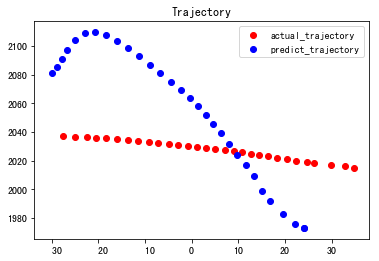

Test Loss: 0.0009664455283200368
actuale_angle_0:-1.4735427138815567,prdict_angle_0:-1.5407459571119915
actuale_angle_1:-1.474492262589421,prdict_angle_1:-1.5404900562585453
actuale_angle_2:-1.4735427138815684,prdict_angle_2:-1.5411197070767713
actuale_angle_3:-1.4745937280161328,prdict_angle_3:-1.540823125875166
actuale_angle_4:-1.4735446176985232,prdict_angle_4:-1.541463492201676
actuale_angle_5:-1.4745937280161345,prdict_angle_5:-1.5410595797788127
actuale_angle_6:-1.473440153904065,prdict_angle_6:-1.5416580968022804
actuale_angle_7:-1.474593728016123,prdict_angle_7:-1.5411607454375138
actuale_angle_8:-1.477598935115414,prdict_angle_8:-1.5417462263054182
actuale_angle_9:-1.461741851698943,prdict_angle_9:-1.5446619456888162
actuale_angle_10:-1.4280330998251214,prdict_angle_10:-1.536981133590913
actuale_angle_11:-1.3712644134323233,prdict_angle_11:-1.5190654983013252
actuale_angle_12:-1.6109461651689831,prdict_angle_12:-1.4906121339595217
actuale_angle_13:-1.5906414366251513,prdict_an

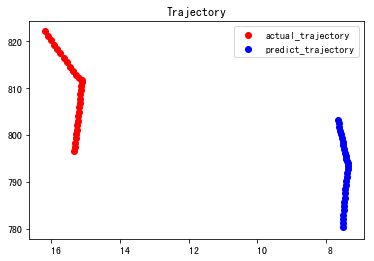

Test Loss: 0.0013680641908043374
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
act

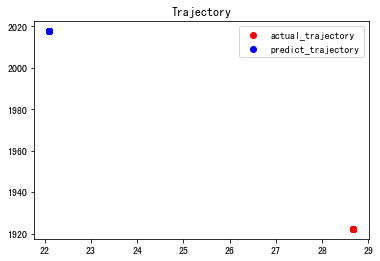

Test Loss: 0.0012896592888864689
actuale_angle_0:2.283180892358394,prdict_angle_0:2.019275781756791
actuale_angle_1:1.4160780064429115,prdict_angle_1:-1.8201419469853684
actuale_angle_2:1.0547048537908261,prdict_angle_2:1.4903973799109453
actuale_angle_3:0.12266913341101164,prdict_angle_3:1.0536016868976774
actuale_angle_4:-0.6369833094519128,prdict_angle_4:-1.3777262463270181
actuale_angle_5:-1.496105941227737,prdict_angle_5:-1.014394196009599
actuale_angle_6:-1.769092658544223,prdict_angle_6:-1.4490816451879274
actuale_angle_7:-2.399044726705906,prdict_angle_7:-1.7050131510941813
actuale_angle_8:-2.6618394587735397,prdict_angle_8:-2.5835269938681846
actuale_angle_9:-2.7907909372569217,prdict_angle_9:-2.7469596429139838
actuale_angle_10:-0.942474471493067,prdict_angle_10:2.1332625840899855
actuale_angle_11:-1.2338219410256792,prdict_angle_11:-1.3882076432139994
actuale_angle_12:-1.8357090588474285,prdict_angle_12:-1.013426792613969
actuale_angle_13:-2.494128622828284,prdict_angle_13:-

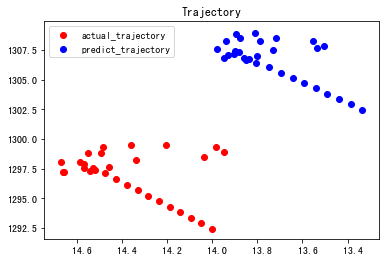

Test Loss: 0.0017328187765087931
actuale_angle_0:2.7892316996276914,prdict_angle_0:1.9368266891737538
actuale_angle_1:2.7914958390934816,prdict_angle_1:1.9265487926622396
actuale_angle_2:2.8014663544916574,prdict_angle_2:1.9081427088647611
actuale_angle_3:2.782916378255573,prdict_angle_3:1.8942320131284474
actuale_angle_4:2.7747308547362106,prdict_angle_4:1.911005857942859
actuale_angle_5:2.7378441378999874,prdict_angle_5:1.9254033894742186
actuale_angle_6:2.7400457772840126,prdict_angle_6:1.9196433861880946
actuale_angle_7:2.7572434802040875,prdict_angle_7:1.914135050321968
actuale_angle_8:2.7931470869462554,prdict_angle_8:1.9391005635310317
actuale_angle_9:2.840467251062483,prdict_angle_9:2.026185697902406
actuale_angle_10:2.9116930443374116,prdict_angle_10:2.413469343284334
actuale_angle_11:2.96344078582645,prdict_angle_11:-2.956456989151675
actuale_angle_12:2.980119477393514,prdict_angle_12:-2.215567001067966
actuale_angle_13:2.9771453317986087,prdict_angle_13:-1.8184924546719587
a

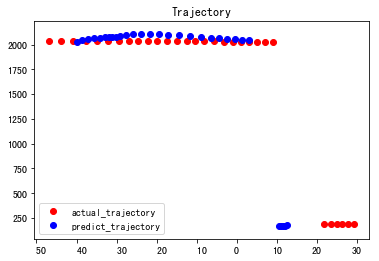

Test Loss: 0.0015789573323369648
actuale_angle_0:-1.5698037791023465,prdict_angle_0:-1.556610356089016
actuale_angle_1:-1.5701373569842365,prdict_angle_1:-1.553068298648058
actuale_angle_2:-1.5707963267948966,prdict_angle_2:-1.5507443715965263
actuale_angle_3:-1.5686756507116975,prdict_angle_3:-1.5572554620513088
actuale_angle_4:-1.5739783113466899,prdict_angle_4:-1.5566490897688734
actuale_angle_5:-1.565930833515654,prdict_angle_5:-1.5629787111325892
actuale_angle_6:-1.5487349289744565,prdict_angle_6:-1.554238844611256
actuale_angle_7:-1.5429866307230293,prdict_angle_7:-1.5416054009127333
actuale_angle_8:-1.5500868458422299,prdict_angle_8:-1.539749987651176
actuale_angle_9:-1.5279735595170325,prdict_angle_9:-1.5450945032787908
actuale_angle_10:-1.5744882360483585,prdict_angle_10:-1.528226197719483
actuale_angle_11:-1.6117361413974352,prdict_angle_11:-1.5484637960066798
actuale_angle_12:-1.6454798958457015,prdict_angle_12:-1.5733574542983473
actuale_angle_13:-1.6041174541681023,prdict_

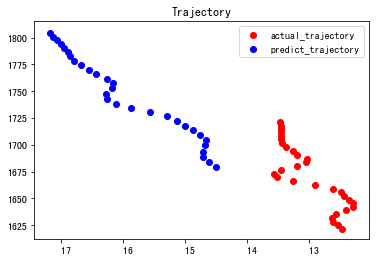

Test Loss: 0.0017071085790770926
actuale_angle_0:1.611340411429508,prdict_angle_0:1.6276463271976036
actuale_angle_1:1.6111858130212369,prdict_angle_1:1.6275850093090183
actuale_angle_2:1.6130465574600457,prdict_angle_2:1.628138516885047
actuale_angle_3:1.6122432093307741,prdict_angle_3:1.6290939260479138
actuale_angle_4:1.6039205097821954,prdict_angle_4:1.6265846982208205
actuale_angle_5:1.593519792379635,prdict_angle_5:1.6196339107038316
actuale_angle_6:1.5846363306076292,prdict_angle_6:1.6083369519065787
actuale_angle_7:1.5871754993038463,prdict_angle_7:1.6038861317854582
actuale_angle_8:1.5953975977277364,prdict_angle_8:1.604962118433
actuale_angle_9:1.573105736201589,prdict_angle_9:1.6107411298412615
actuale_angle_10:1.5377784583761207,prdict_angle_10:1.5836953163357577
actuale_angle_11:1.512880411841557,prdict_angle_11:1.5590195148729524
actuale_angle_12:1.4744217765031298,prdict_angle_12:1.5396018733222012
actuale_angle_13:1.4888590559936947,prdict_angle_13:1.5093519255193468
ac

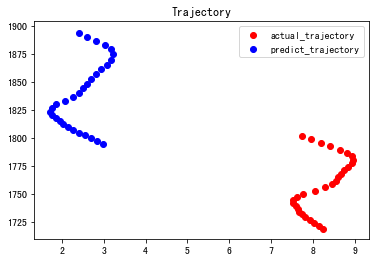

Test Loss: 0.0019474730834190268
actuale_angle_0:2.1705581390765794,prdict_angle_0:1.9645524583540284
actuale_angle_1:2.0970242361945792,prdict_angle_1:1.9595790176129055
actuale_angle_2:2.142563820580061,prdict_angle_2:1.9277572289692055
actuale_angle_3:2.137939826439909,prdict_angle_3:1.928704495338284
actuale_angle_4:2.1355314300327874,prdict_angle_4:1.943966590626525
actuale_angle_5:2.138395477173884,prdict_angle_5:1.9604363039442627
actuale_angle_6:2.140637006275519,prdict_angle_6:1.9623784128422441
actuale_angle_7:2.1410678671596113,prdict_angle_7:1.971466663954257
actuale_angle_8:2.1433421921795524,prdict_angle_8:1.981821610062101
actuale_angle_9:2.1443794844054747,prdict_angle_9:1.9941779769427572
actuale_angle_10:2.1451896244935016,prdict_angle_10:2.008874114968351
actuale_angle_11:2.146604066784933,prdict_angle_11:2.031327482222195
actuale_angle_12:2.1490756153209367,prdict_angle_12:2.0628019727644635
actuale_angle_13:2.132748016427827,prdict_angle_13:2.0446416268654826
actua

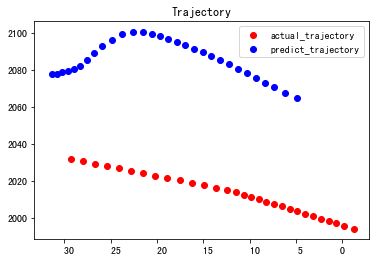

Test Loss: 0.0017507723209241198
actuale_angle_0:-1.6368158375892892,prdict_angle_0:-1.6140992127915224
actuale_angle_1:-1.6347584696825463,prdict_angle_1:-1.6136355211258842
actuale_angle_2:-1.6357203609510538,prdict_angle_2:-1.6124383941357032
actuale_angle_3:-1.6357203609510538,prdict_angle_3:-1.6119038612831664
actuale_angle_4:-1.6355875138074565,prdict_angle_4:-1.6111830710981565
actuale_angle_5:-1.6355205980307994,prdict_angle_5:-1.6106090384702594
actuale_angle_6:-1.6370888947090232,prdict_angle_6:-1.6102080865640356
actuale_angle_7:-1.6342032996363598,prdict_angle_7:-1.6100326007030596
actuale_angle_8:-1.6316569629570015,prdict_angle_8:-1.6083182220803518
actuale_angle_9:-1.6296175664481296,prdict_angle_9:-1.6063366554859153
actuale_angle_10:-1.627359343321943,prdict_angle_10:-1.6047986831898424
actuale_angle_11:-1.633510421624696,prdict_angle_11:-1.6091483141428344
actuale_angle_12:-1.6485803443539273,prdict_angle_12:-1.60952885594221
actuale_angle_13:-1.7327321750714015,prdic

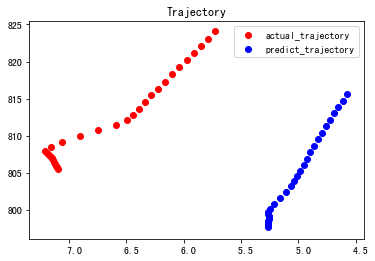

Test Loss: 0.001602757250657305
actuale_angle_0:-1.5519168492744821,prdict_angle_0:-0.9055537153382714
actuale_angle_1:1.736418077308526,prdict_angle_1:1.632884607301212
actuale_angle_2:1.5707963267948966,prdict_angle_2:-1.5687665267250475
actuale_angle_3:1.5707963267948966,prdict_angle_3:-1.6725989726840544
actuale_angle_4:-1.5707963267948966,prdict_angle_4:1.5696451155363211
actuale_angle_5:0.0,prdict_angle_5:-1.6207880735715827
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0

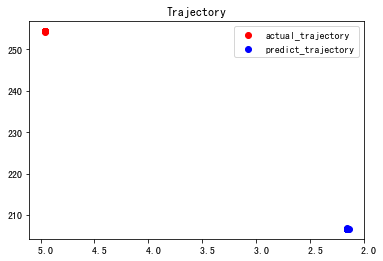

Test Loss: 0.0015092996340668337
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:-1.5707963267948966,prdict_angle_3:0.0
actuale_angle_4:1.5707963267948966,prdict_angle_4:-1.6233746462271008
actuale_angle_5:1.5707963267948966,prdict_angle_5:1.5862921678616118
actuale_angle_6:2.1366834004149773,prdict_angle_6:1.6602472941195052
actuale_angle_7:-1.5199984623510054,prdict_angle_7:-1.5693733647632535
actuale_angle_8:-1.4025649315671744,prdict_angle_8:-1.6173976924900249
actuale_angle_9:-1.3511683908018743,prdict_angle_9:-1.4664310686481103
actuale_angle_10:-1.3510394646452393,prdict_angle_10:-1.4351792883263819
actuale_angle_11:-1.3650212776686614,prdict_angle_11:-1.3283131962206216
actuale_angle_12:-1.3765030887798326,prdict_angle_12:-1.3551969177435141
actuale_angle_13:-1.3741138693492756,prdict_angle_13:-1.416090542215988
actuale_angle_14:-1.3701845340093717,prdict_angle_14:-1.4475135486131683
actuale_an

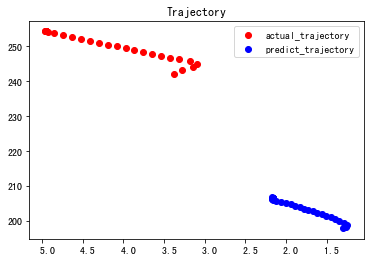

Test Loss: 0.0015630312506497528
actuale_angle_0:-1.5565770782719268,prdict_angle_0:-1.463227695655382
actuale_angle_1:-1.593211646690128,prdict_angle_1:-1.5251597590249206
actuale_angle_2:-1.6229299727040616,prdict_angle_2:-1.5595814740170084
actuale_angle_3:-1.641737244492666,prdict_angle_3:-1.586999080850896
actuale_angle_4:-1.6370386467848974,prdict_angle_4:-1.6039013532725914
actuale_angle_5:-1.6432607619815154,prdict_angle_5:-1.60263026736443
actuale_angle_6:-1.6871553547669094,prdict_angle_6:-1.6234897138290374
actuale_angle_7:-1.6977511753365608,prdict_angle_7:-1.6405528035853956
actuale_angle_8:-1.6405967462187567,prdict_angle_8:-1.648975459183238
actuale_angle_9:-1.5879372429213694,prdict_angle_9:-1.611573675563291
actuale_angle_10:-1.5548253120040951,prdict_angle_10:-1.5737178486248689
actuale_angle_11:-1.5733656374333587,prdict_angle_11:-1.5494795176866312
actuale_angle_12:-1.6030520461572586,prdict_angle_12:-1.5653577337159228
actuale_angle_13:-1.6331618236763759,prdict_an

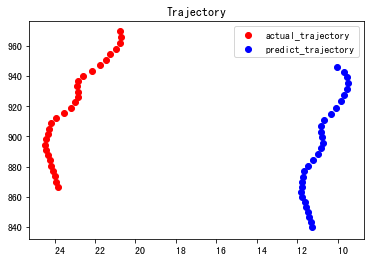

Test Loss: 0.0014865043116375231
actuale_angle_0:-0.45734657881070534,prdict_angle_0:0.8364486768387199
actuale_angle_1:-0.6093411274288606,prdict_angle_1:0.7131406502228154
actuale_angle_2:-0.7765259750633857,prdict_angle_2:0.4574329788342021
actuale_angle_3:-0.9116393563183095,prdict_angle_3:-0.0010415046533667175
actuale_angle_4:-0.9695178190953229,prdict_angle_4:-0.3611270444765742
actuale_angle_5:-0.9798135027783823,prdict_angle_5:-0.5252792280612957
actuale_angle_6:-0.9902142446462232,prdict_angle_6:-0.7566819788243461
actuale_angle_7:-1.0080374326316894,prdict_angle_7:-0.818830434198223
actuale_angle_8:-1.0259523329737552,prdict_angle_8:-0.8892231722047604
actuale_angle_9:-1.041467766806604,prdict_angle_9:-0.9535392609883586
actuale_angle_10:-1.056508806697963,prdict_angle_10:-1.006369658385793
actuale_angle_11:-1.0664089414969729,prdict_angle_11:-1.050154189576382
actuale_angle_12:-1.070343722477817,prdict_angle_12:-1.3273768227473326
actuale_angle_13:-1.0851158793730016,prdict

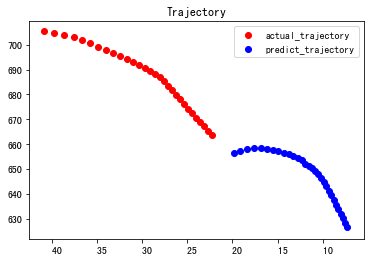

Test Loss: 0.0014172674979948039
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
act

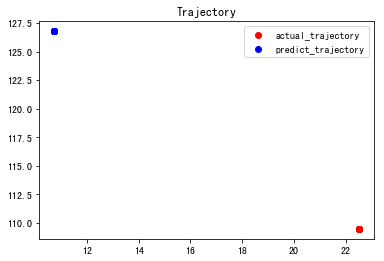

Test Loss: 0.0013307708577485755
actuale_angle_0:1.4503788239078839,prdict_angle_0:1.3702985856553758
actuale_angle_1:1.4453782224327816,prdict_angle_1:1.38339704256266
actuale_angle_2:1.4609464896049904,prdict_angle_2:1.4193191463758041
actuale_angle_3:1.4588563114795565,prdict_angle_3:1.435752658271842
actuale_angle_4:1.4505496339357553,prdict_angle_4:1.4657683713034793
actuale_angle_5:1.4456203146038185,prdict_angle_5:1.469037493771627
actuale_angle_6:1.4753811209856782,prdict_angle_6:1.46534288667344
actuale_angle_7:1.4984547571805713,prdict_angle_7:1.4615778420019085
actuale_angle_8:1.5212914379210967,prdict_angle_8:1.4612886546125112
actuale_angle_9:1.5563650761601733,prdict_angle_9:1.4648970839701654
actuale_angle_10:1.553023323117354,prdict_angle_10:1.467502640470428
actuale_angle_11:1.5366960476142062,prdict_angle_11:1.466745161900585
actuale_angle_12:1.5285818176485821,prdict_angle_12:1.4651563513889796
actuale_angle_13:1.5294176180668568,prdict_angle_13:1.4643981774422639
ac

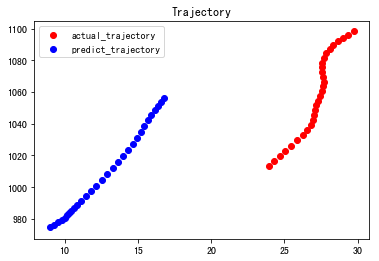

Test Loss: 0.0013401571368376608
actuale_angle_0:1.4650597392728886,prdict_angle_0:1.4846380776193577
actuale_angle_1:1.4902126144963763,prdict_angle_1:1.5035544702061436
actuale_angle_2:1.5086985159531887,prdict_angle_2:1.5217131110447575
actuale_angle_3:1.521665132319668,prdict_angle_3:1.5329453344507844
actuale_angle_4:1.5088380656496072,prdict_angle_4:1.5415438573562001
actuale_angle_5:1.4911878878388696,prdict_angle_5:1.5288471707605897
actuale_angle_6:1.4934791792824487,prdict_angle_6:1.5132337828218454
actuale_angle_7:1.5202260460082746,prdict_angle_7:1.5152785538564297
actuale_angle_8:1.5359885127751882,prdict_angle_8:1.536978693103825
actuale_angle_9:1.5556765005022972,prdict_angle_9:1.5522972077052006
actuale_angle_10:1.5593094784487376,prdict_angle_10:1.5636778063359202
actuale_angle_11:1.5653183424416233,prdict_angle_11:1.565114105066181
actuale_angle_12:1.5800939144162138,prdict_angle_12:1.5676989952492941
actuale_angle_13:1.5888995189030268,prdict_angle_13:1.5862177515484

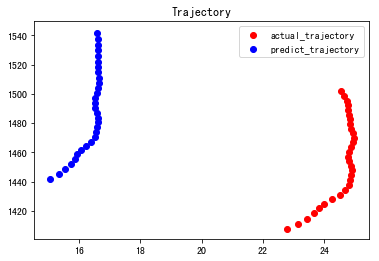

Test Loss: 0.0012910526839892984
actuale_angle_0:1.6204469476058943,prdict_angle_0:1.6509834523704736
actuale_angle_1:1.6299732346831983,prdict_angle_1:1.6329082298017539
actuale_angle_2:1.631107212342765,prdict_angle_2:1.6407465327721518
actuale_angle_3:1.6327472061888342,prdict_angle_3:1.640591500824985
actuale_angle_4:1.6338064708946016,prdict_angle_4:1.6411512137666047
actuale_angle_5:1.630373403621074,prdict_angle_5:1.621885025810906
actuale_angle_6:1.6305123021032606,prdict_angle_6:1.601568387054127
actuale_angle_7:1.6308254562359015,prdict_angle_7:1.6273750746768967
actuale_angle_8:1.6313297176383992,prdict_angle_8:1.6423299029228247
actuale_angle_9:1.6306064856798541,prdict_angle_9:1.6386698588968638
actuale_angle_10:1.6306104997224968,prdict_angle_10:1.6379558645266352
actuale_angle_11:1.6306077886085308,prdict_angle_11:1.6379458311918271
actuale_angle_12:1.6306539109559806,prdict_angle_12:1.6379848718719963
actuale_angle_13:1.6306511959100969,prdict_angle_13:1.638137243616968

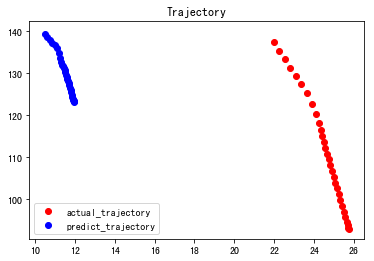

Test Loss: 0.00128041228405588
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:-1.7874861109369586
actuale_angle_12:0.0,prdict_angle_12:1.3541065426528345
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:-1.7874861109369586
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0

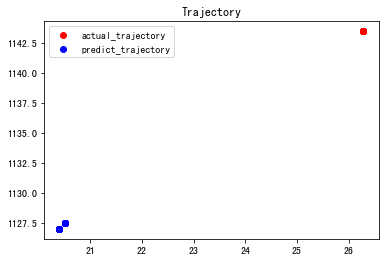

Test Loss: 0.001223721834034414
actuale_angle_0:0.0,prdict_angle_0:0.0
actuale_angle_1:0.0,prdict_angle_1:0.0
actuale_angle_2:0.0,prdict_angle_2:0.0
actuale_angle_3:0.0,prdict_angle_3:0.0
actuale_angle_4:0.0,prdict_angle_4:0.0
actuale_angle_5:0.0,prdict_angle_5:0.0
actuale_angle_6:0.0,prdict_angle_6:0.0
actuale_angle_7:0.0,prdict_angle_7:0.0
actuale_angle_8:0.0,prdict_angle_8:0.0
actuale_angle_9:0.0,prdict_angle_9:0.0
actuale_angle_10:0.0,prdict_angle_10:0.0
actuale_angle_11:0.0,prdict_angle_11:0.0
actuale_angle_12:0.0,prdict_angle_12:0.0
actuale_angle_13:0.0,prdict_angle_13:0.0
actuale_angle_14:0.0,prdict_angle_14:0.0
actuale_angle_15:0.0,prdict_angle_15:0.0
actuale_angle_16:0.0,prdict_angle_16:0.0
actuale_angle_17:0.0,prdict_angle_17:0.0
actuale_angle_18:0.0,prdict_angle_18:0.0
actuale_angle_19:0.0,prdict_angle_19:0.0
actuale_angle_20:0.0,prdict_angle_20:0.0
actuale_angle_21:0.0,prdict_angle_21:0.0
actuale_angle_22:0.0,prdict_angle_22:0.0
actuale_angle_23:0.0,prdict_angle_23:0.0
actu

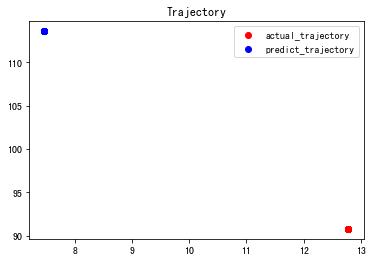

Test Loss: 0.0012039143693982624
actuale_angle_0:1.5083613687005029,prdict_angle_0:1.558519469033591
actuale_angle_1:1.4644814567585969,prdict_angle_1:1.5559347941158224
actuale_angle_2:1.4223244174727026,prdict_angle_2:1.5529767094320657
actuale_angle_3:1.3796822917823266,prdict_angle_3:1.550441734178137
actuale_angle_4:1.4179564340197208,prdict_angle_4:1.5481827175996825
actuale_angle_5:1.472445035605721,prdict_angle_5:1.5495583864278153
actuale_angle_6:1.527156137862572,prdict_angle_6:1.552285247014641
actuale_angle_7:1.574978399795966,prdict_angle_7:1.5227276900142643
actuale_angle_8:1.6315263391529478,prdict_angle_8:1.557759885109929
actuale_angle_9:1.6018486932391522,prdict_angle_9:1.5610281818857157
actuale_angle_10:1.5667176155320512,prdict_angle_10:1.5592500013579376
actuale_angle_11:1.5183717098999518,prdict_angle_11:1.5561758529535663
actuale_angle_12:1.4662834606493584,prdict_angle_12:1.552137141493252
actuale_angle_13:1.424431225291176,prdict_angle_13:1.5479596615286464
ac

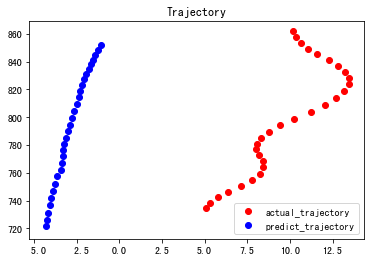

In [24]:
net_test = LSTM(1,2,256,2)
if train_on_gpu:
    net_test.cuda()
    
net_test.load_state_dict(torch.load('model/lstm_trajectory_prediction_old_mean.pt'))
test(net_test,train_loader)
actual_angles,predict_angles = predict(net_test,train_loader)

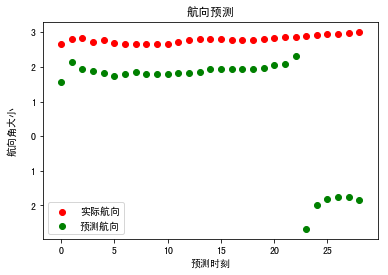

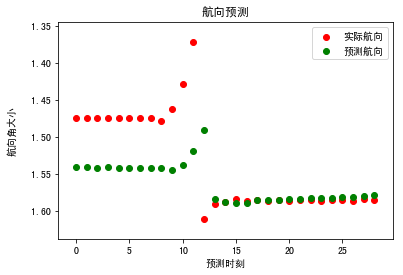

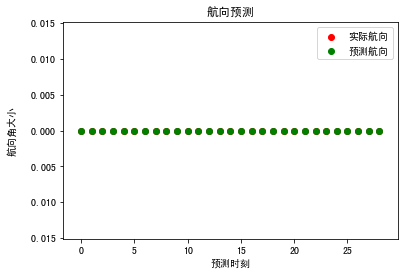

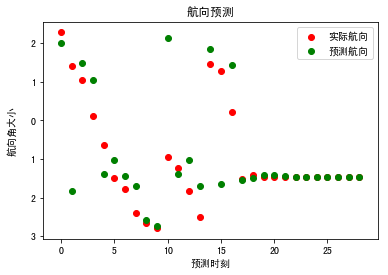

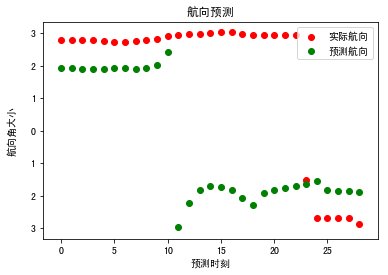

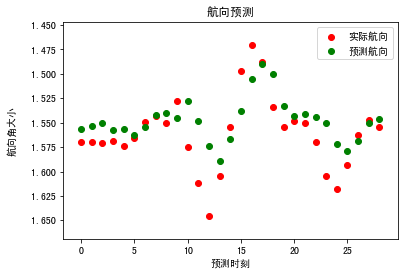

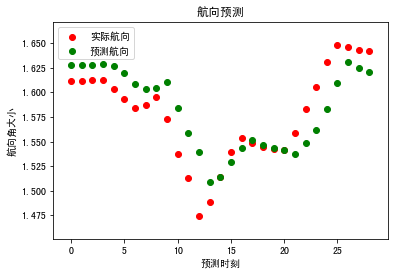

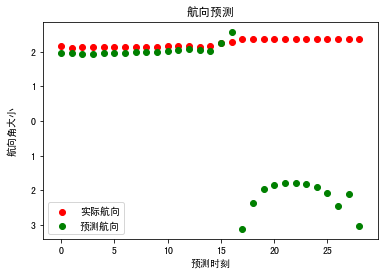

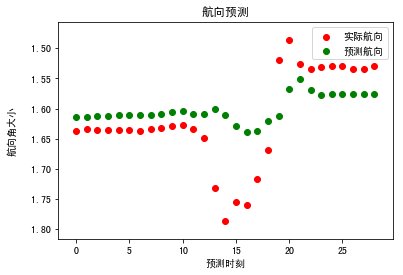

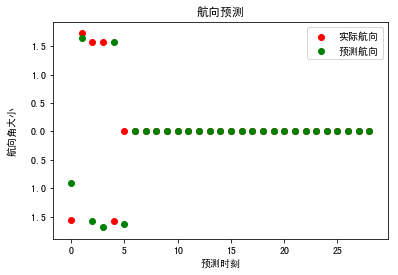

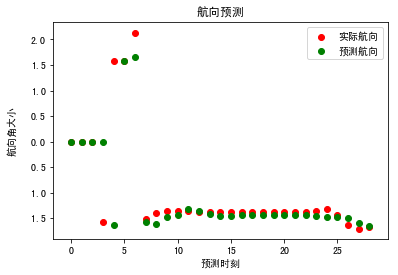

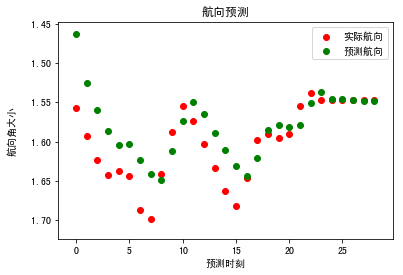

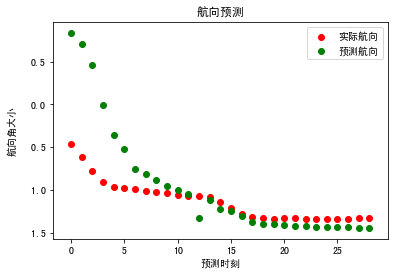

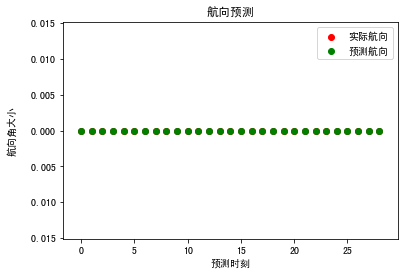

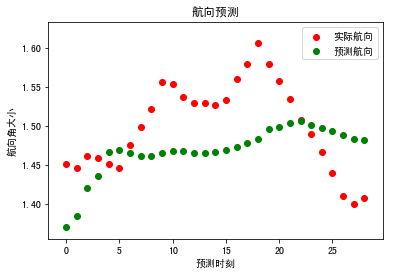

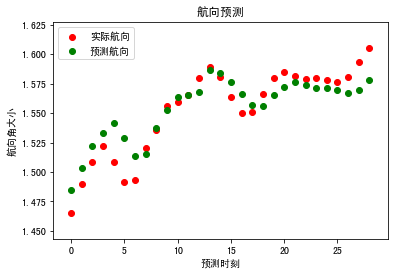

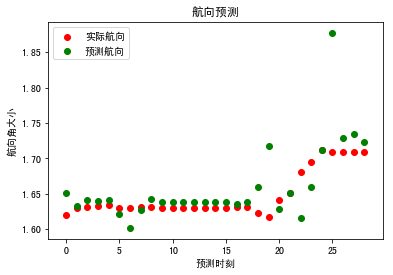

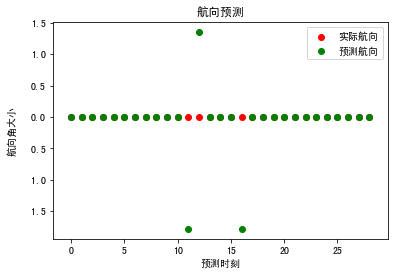

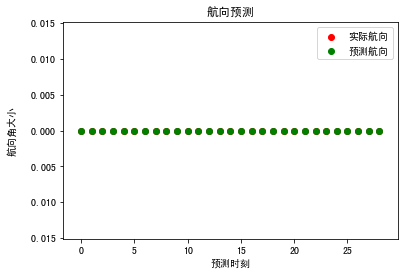

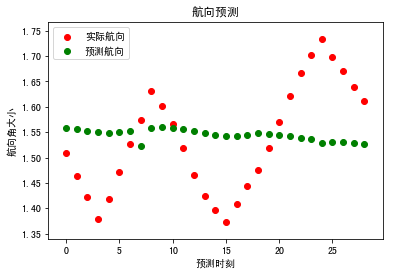

In [27]:
i_= 0
for i in range(0,len(actual_angles),29):
    plt.scatter([range(len(actual_angles[i:i+29]))],actual_angles[i:i+29],color='r',label='实际航向')
    plt.scatter([range(len(predict_angles[i:i+29]))],predict_angles[i:i+29],color='g',label='预测航向')
    #plt.title('Loss_Trend')
    #plt.xlabel('Epoches')
    #plt.ylabel('Loss')
    plt.title('航向预测')
    plt.xlabel('预测时刻')
    plt.ylabel('航向角大小')
    plt.legend()
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.savefig('trajectory_image/航向_old_mean/svg/航向_old_mean_{}.svg'.format(i_),dpi=300)
    plt.savefig('trajectory_image/航向_old_mean/png/航向_old_mean_{}.png'.format(i_),dpi=300)
    i_ += 1
    plt.show()